In [85]:
import pickle
import matplotlib.pyplot as plt
import torch
import io, math
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from s2aenso.utils import data, normalization, metric
from s2aenso.utils.utilities import *

PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/"

#####################################################################################################################################################################
###------------------------------------------------ Specify Models -----------------------------------------------------------------------------------------------###
#####################################################################################################################################################################

models_vit_single = [(765368, "1_2g_allV")]
models_swin_single = [(778521, "new_baseline")]

dataset = "godas"                                   # "cesm2_picontrol" or "oras5" or "godas"
specification = "acc_delta_try"

save_dir = f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/final_plots/{dataset}/{specification}/"
create_directory(save_dir)


In [86]:
#####################################################################################################################################################################
###------------------------------------------------ Load Data ----------------------------------------------------------------------------------------------------###
#####################################################################################################################################################################

data_vit_single = []
data_swinlstm_single = []

# Load single data
for model_num in models_vit_single:
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_vit_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:
        cfg_vit_single = CPU_Unpickler(file).load()
        data_vit_single.append((cfg_vit_single, model_num[1]))

for model_num in models_swin_single:
    print("Model number: ", model_num)
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_swinlstm_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:   
        cfg_swin_single = CPU_Unpickler(file).load()
        data_swinlstm_single.append((cfg_swin_single, model_num[1]))


Model number:  (778521, 'new_baseline')


In [87]:
device= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/"


# Load the configuration files
cfg_vit = data_vit_single[0][0]["config"]

# Selecting the data directories
if cfg_vit["temp_ocean"]:
    cfg_vit["data_dir"] = PATH + '/../../data/processed_data/cesm2_lens/piControl/test/'
else:
    cfg_vit["data_dir"] = PATH + '/../../data/processed_data/cesm2_lens/piControl/sst_ssh/'

cfg_vit["lsm_path"] = PATH + '/../data/processed_data/enso_data_pacific/land_sea_mask_common.nc'
cfg_vit["oras5_dir"] = PATH + '/../data/processed_data/enso_data_pacific/oras5/'


# Load common land sea mask
common_lsm = xr.open_dataset(cfg_vit['lsm_path'])['lsm'].data
lsm = torch.as_tensor(common_lsm, device = device, dtype = torch.long)


# Load the validation xarray dataset
if cfg_vit["1_2_grid"]:
    val_ds_adapt = xr.open_dataset(PATH + "/evaluation/results/val_ds_adapt_1_2_grid.nc")
else:
    val_ds_adapt = xr.open_dataset(PATH + "/evaluation/results/val_ds_adapt.nc")

lsm = common_lsm[cfg_vit["lat_range"][0]:cfg_vit["lat_range"][1], cfg_vit["lon_range"][0]:cfg_vit["lon_range"][1]]


# Adjust the grid region if 1_2_grid is set to True
if cfg_vit["adjust_grid_region"]:
    val_ds_adapt = val_ds_adapt.sel(lat=slice(-26, 25), lon=slice(148, 279))
    lsm = lsm[:51, 29:95]

C:\Users\felix\AppData\Local\Temp\ipykernel_10972\3018578635.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "", '180°', "", "", '120°W'])
C:\Users\felix\AppData\Local\Temp\ipykernel_10972\3018578635.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "", '180°', "", "", '120°W'])
C:\Users\felix\AppData\Local\Temp\ipykernel_10972\3018578635.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "", '180°', "", "", '120°W'])
C:\Users\felix\AppData\Local\Temp\ipykernel_10972\3018578635.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 0.8])  # Adjust rect fo

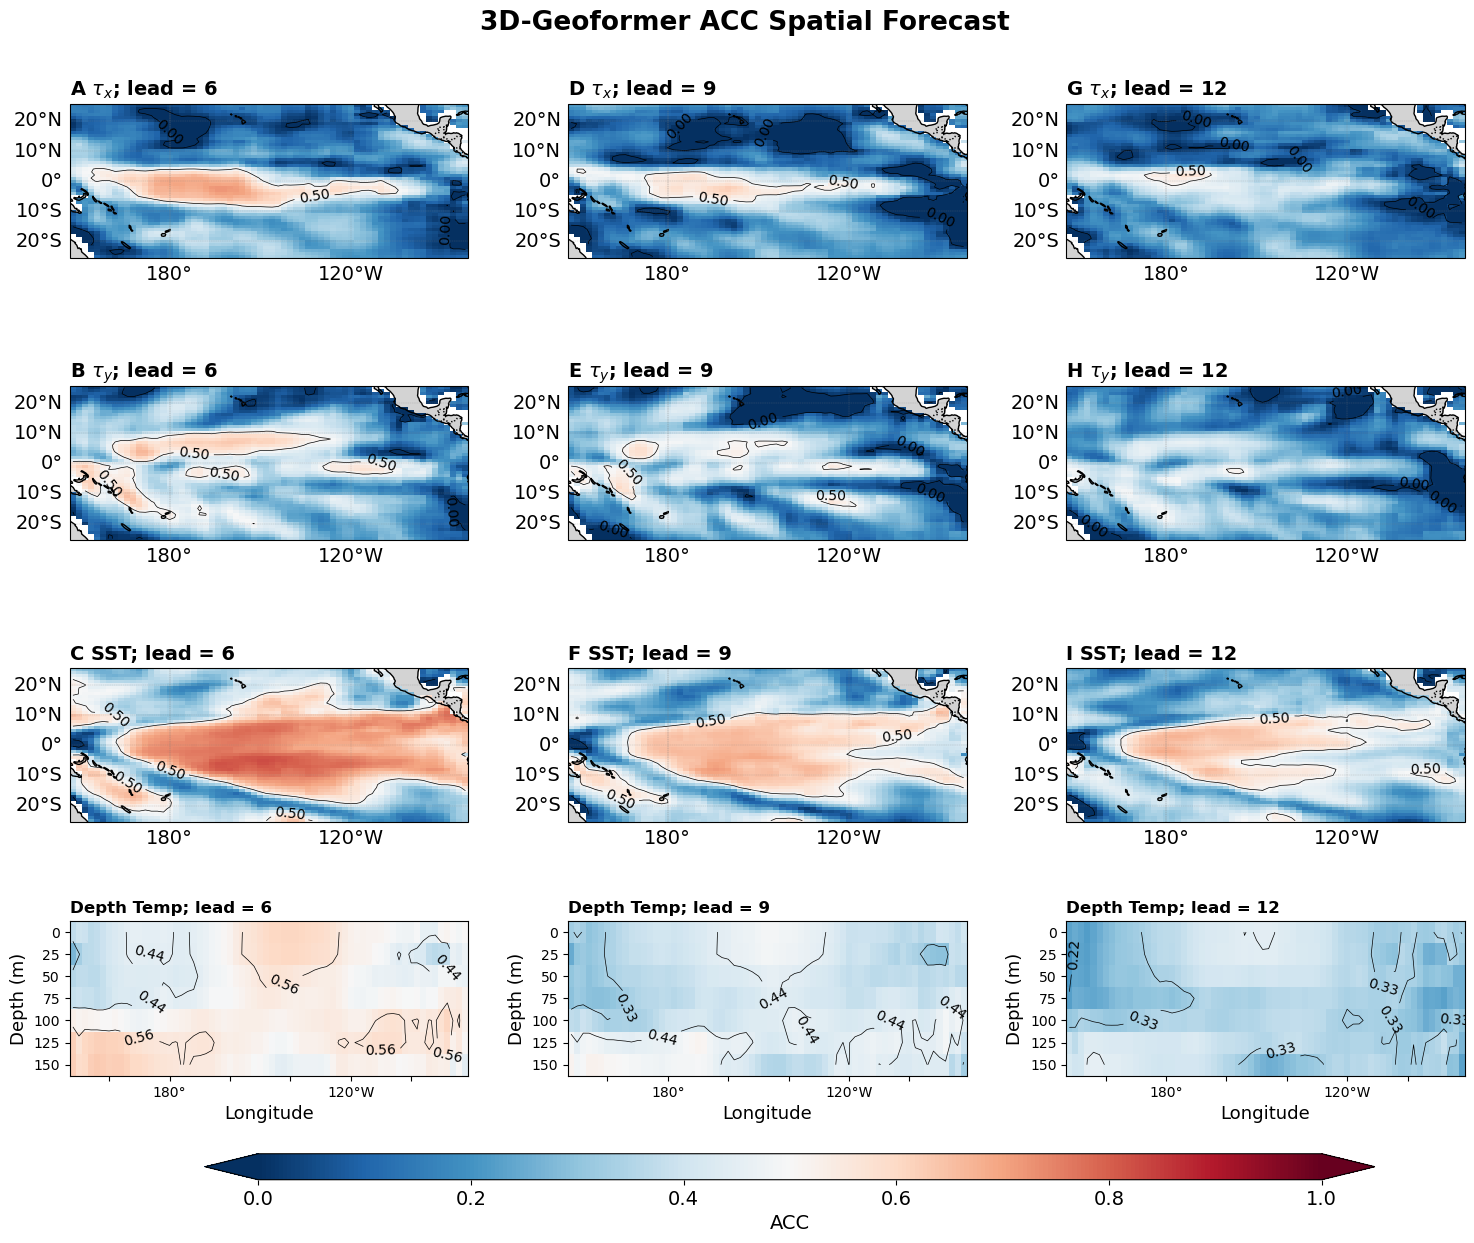

In [181]:
# ===========================================================================================================================
# ACC Spatial Forecast Plot with Combined Depth-Dependent Bottom Row
# ===========================================================================================================================

# ===========================================================================================================================
# Adjusted ACC Spatial Forecast Plot with Reduced Spacing and Aligned X-Axis Labels
# ===========================================================================================================================

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Example data and variables (replace with actual data)
vit_acc = data_vit_single[0][0]["acc"]["total"]["acc_mean_spatial"]
lags = [6, 9, 12]
variables = [r'$\tau_x$', r'$\tau_y$', "SST", "Temperature"]

# Initialize figure and GridSpec layout
fig = plt.figure(figsize=(18, 13))  # Slightly reduced height for compactness
gs = GridSpec(4, 3, figure=fig, height_ratios=[1.1, 1.1, 1.1, 0.8], hspace=0.35, wspace=0.25)  # Reduced 3rd to 4th row spacing
# Colormap and color limits
cmap = 'RdBu_r'
vmin, vmax = 0.0, 1.0

# Plot the first three rows
for col, lag in enumerate(lags):
    for row, var in enumerate(variables[:-1]):  # Skip the last variable for the top rows
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree(central_longitude=180))

        # Retrieve data for each variable
        vit_acc_lag = vit_acc[lag - 1]
        if row == 0:
            vit_acc_var = vit_acc_lag[7]
            data = xr.DataArray(vit_acc_var, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})
        elif row == 1:
            vit_acc_var = vit_acc_lag[8]
            data = xr.DataArray(vit_acc_var, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})
        elif row == 2:
            vit_acc_var = vit_acc_lag[0]
            data = xr.DataArray(vit_acc_var, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})

        # Plot ACC values
        im = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

        # Add contour lines
        contour = ax.contour(data.lon, data.lat, data, levels=np.linspace(vmin, vmax, 3), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
        ax.clabel(contour, fmt='%1.2f', inline=True, fontsize=10)

        # Add coastlines and features
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        # Set the title
        ax.set_title(f"{chr(65 + row + col * 3)} {var}; lead = {lag}", fontsize=14, weight='bold', loc='left')

        # Customize gridlines
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'fontsize': 14}
        gl.ylabel_style = {'fontsize': 14}

# Plot the bottom row for depth vs longitude
for col, lag in enumerate(lags):
    ax = fig.add_subplot(gs[3, col])  # Use the last row in GridSpec

    # Define depth and longitude dimensions
    depth_indices = range(0, 7)  # Replace with actual depth levels
    depth_levels = np.linspace(0, 150, len(depth_indices))  # Replace with actual depth values
    vit_acc_lag = vit_acc[lag - 1]  # Shape: [level, latitude, longitude]

    # Stack data across depth levels and average over latitude
    vit_acc_lag_stacked = np.stack([vit_acc_lag[level] for level in depth_indices], axis=0)  # Shape: [level, latitude, longitude]
    vit_acc_lag_lat_avg = np.nanmean(vit_acc_lag_stacked, axis=1)  # Shape: [level, longitude]

    # Convert to xarray for easier handling
    vit_acc_lag_lat_avg = xr.DataArray(
        vit_acc_lag_lat_avg,
        dims=['depth', 'lon'],
        coords={'depth': depth_levels, 'lon': val_ds_adapt.lon}
    )

    # Plot the depth vs longitude data
    im = ax.pcolormesh(
        vit_acc_lag_lat_avg.lon, vit_acc_lag_lat_avg.depth, vit_acc_lag_lat_avg,
        cmap=cmap, vmin=vmin, vmax=vmax, shading='auto'
    )

    # Add contour lines
    contour = ax.contour(
        vit_acc_lag_lat_avg.lon, vit_acc_lag_lat_avg.depth, vit_acc_lag_lat_avg,
        levels=np.linspace(vmin, vmax, 10), colors='black', linewidths=0.5
    )
    ax.clabel(contour, fmt='%1.2f', inline=True, fontsize=10)

    # Customize ticks and labels
    #ax.set_xticks([180, 120])  # Represent 180° and 120° W like the rows above
    #ax.set_xticklabels(['180°', '120°W'])
    ax.set_yticks(depth_levels)
    ax.set_xticklabels(["", "", '180°', "", "", '120°W'])
    ax.set_xlabel('Longitude', fontsize=13)
    ax.set_ylabel('Depth (m)', fontsize=13)
    ax.set_title(f"Depth Temp; lead = {lag}", fontsize=12, weight='bold', loc='left')

    # Invert the y-axis for depth
    ax.invert_yaxis()

# Add a shared colorbar below all plots
cbar_ax = fig.add_axes([0.2, 0.03, 0.65, 0.02])  # Adjust position for compactness
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('ACC', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add a main title
plt.suptitle("3D-Geoformer ACC Spatial Forecast", fontsize=19, weight='bold', y=0.93)

# Save and show the figure
plt.tight_layout(rect=[0, 0.2, 1, 0.8])  # Adjust rect for tighter layout
plt.show()
fig.savefig(f'{save_dir}/acc_spatial_forecast_plot_depth_combined.pdf', dpi=600)


